In [1]:
#import libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Masking, Activation, dot, Embedding 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow.keras.backend as k
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
class globalvars:
    max_len = 100
    nb_features = 5000
    nb_hidden_units = 100
    nb_lstm_cells = 64
    nb_classes = 3
    masking_value = 0.0
    globalVar = 0


In [3]:
#dataset loading
csv_file_path1 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/all-data.csv"
csv_file_path2 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/RoBERTaWeaklyLabelling.csv"

try:
    df1 = pd.read_csv(csv_file_path1, encoding='utf-8')
except UnicodeDecodeError:
    df1 = pd.read_csv(csv_file_path1, encoding='latin1')

try:
    df2 = pd.read_csv(csv_file_path2, encoding='utf-8')
except UnicodeDecodeError:
    df2 = pd.read_csv(csv_file_path2, encoding='latin1')

In [4]:
# Concatenate datasets
df = pd.concat([df1, df2], ignore_index=True)

# Data Preprocessing
stop_words = set(stopwords.words('english'))

df['label'] = df['label'].apply(lambda x: x.lower())

In [5]:
#data preprocessing
def preprocess_text(text):
    text = re.sub(r'\W', ' ', str(text))
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'^b\s+', '', text)
    text = text.lower()
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    return ' '.join(text)

df['processed_text'] = df['news'].apply(preprocess_text) 

In [6]:
# Encode Labels using LabelEncoder
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
df

,label,news,processed_text,label_encoded
0,neutral,"According to Gran , the company has no plans t...",according gran company plans move production r...,1
1,neutral,Technopolis plans to develop in stages an area...,technopolis plans develop stages area less 100...,1
2,negative,The international electronic industry company ...,international electronic industry company elco...,0
3,positive,With the new production plant the company woul...,new production plant company would increase ca...,2
4,positive,According to the company 's updated strategy f...,according company updated strategy years 2009 ...,2
...,...,...,...,...
77155,neutral,Decision needed on BoE's ECB stake after Brexi...,decision needed boe ecb stake brexit nowotny,1
77156,negative,Breakingviews TV: X factor,breakingviews tv factor,0
77157,positive,BRIEF-MagneGas To Expand Green Arc Sales Force...,brief magnegas expand green arc sales force 60...,2
77158,neutral,Uber introduces new safety features as it figh...,uber introduces new safety features fights ret...,1


In [7]:
df['label_encoded'].unique

<bound method Series.unique of 0        1
1        1
2        0
3        2
4        2
        ..
77155    1
77156    0
77157    2
77158    1
77159    1
Name: label_encoded, Length: 77160, dtype: int32>

In [8]:
X = df['processed_text'].values
y = df['label_encoded'].values

In [9]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
tokenizer = Tokenizer(num_words=globalvars.nb_features + 1, lower=True)  # +1 for masking value
tokenizer.fit_on_texts(X_train)

In [11]:
X_train_feature = tokenizer.texts_to_sequences(X_train)
X_test_feature = tokenizer.texts_to_sequences(X_test)

X_train_feature = pad_sequences(X_train_feature, maxlen=globalvars.max_len)
X_test_feature = pad_sequences(X_test_feature, maxlen=globalvars.max_len)

In [ ]:
# model architecture
def create_model():
    input_feature = Input(shape=(globalvars.max_len,))
    x = Embedding(globalvars.nb_features + 1, 128)(input_feature)
    x = Masking(mask_value=globalvars.masking_value)(x)
    x = Dense(globalvars.nb_hidden_units, activation='tanh')(x)
    x = Dropout(0.2)(x)
    x = Dense(globalvars.nb_hidden_units, activation='tanh')(x)
    x = Dropout(0.2)(x)
    y = Bidirectional(LSTM(globalvars.nb_lstm_cells, return_sequences=True, dropout=0.5))(x)

    input_attention = Input(shape=(globalvars.nb_lstm_cells * 2,))
    u = Dense(globalvars.nb_lstm_cells * 2, activation='softmax')(input_attention)
    alpha = dot([u, y], axes=-1)
    alpha = Activation('softmax')(alpha)
    z = dot([alpha, y], axes=1)

    nb_classes = 3  # Three classes: positive, negative, neutral
    output = Dense(nb_classes, activation='softmax')(z)

    model = Model(inputs=[input_attention, input_feature], outputs=output)

    optimizer = optimizers.Adam()
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

model = create_model()

In [13]:
#early stopping 
callback_list = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        mode='auto'
    )
]

In [14]:
X_train_attention = np.zeros((len(X_train), globalvars.nb_lstm_cells * 2))  
X_test_attention = np.zeros((len(X_test), globalvars.nb_lstm_cells * 2)) 

In [15]:
#model training
history = model.fit(
    [X_train_attention, X_train_feature], y_train,
    epochs=5, batch_size=64,
    validation_data=([X_test_attention, X_test_feature], y_test),
    callbacks=callback_list,
    verbose=1
)

Epoch 1/5
965/965 ━━━━━━━━━━━━━━━━━━━━ 604s 466ms/step - accuracy: 0.6317 - loss: 0.8110 - val_accuracy: 0.8527 - val_loss: 0.4378
Epoch 2/5
965/965 ━━━━━━━━━━━━━━━━━━━━ 576s 598ms/step - accuracy: 0.8672 - loss: 0.4048 - val_accuracy: 0.8639 - val_loss: 0.4240
Epoch 3/5
965/965 ━━━━━━━━━━━━━━━━━━━━ 487s 504ms/step - accuracy: 0.8763 - loss: 0.3700 - val_accuracy: 0.8627 - val_loss: 0.4154
Epoch 4/5
965/965 ━━━━━━━━━━━━━━━━━━━━ 345s 357ms/step - accuracy: 0.8861 - loss: 0.3411 - val_accuracy: 0.8744 - val_loss: 0.3933
Epoch 5/5
965/965 ━━━━━━━━━━━━━━━━━━━━ 395s 409ms/step - accuracy: 0.8917 - loss: 0.3191 - val_accuracy: 0.8754 - val_loss: 0.3830


In [16]:
# Make predictions
y_pred = model.predict([X_test_attention, X_test_feature])
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test to categorical if needed (depends on your model output)
# y_test_cat = to_categorical(y_test, num_classes=globalvars.nb_classes)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


483/483 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step
Accuracy: 0.8754
Precision: 0.8757
Recall: 0.8754
F1-score: 0.8744
              precision    recall  f1-score   support

    negative       0.84      0.77      0.80      3420
     neutral       0.86      0.94      0.90      5386
    positive       0.91      0.87      0.89      6626

    accuracy                           0.88     15432
   macro avg       0.87      0.86      0.86     15432
weighted avg       0.88      0.88      0.87     15432



The model performs well across all sentiment classes with an overall accuracy of 88%.

Neutral and Positive classes have higher precision and recall compared to the Negative class.

The Negative class shows slightly lower recall (0.77), indicating some negative instances are being misclassified.

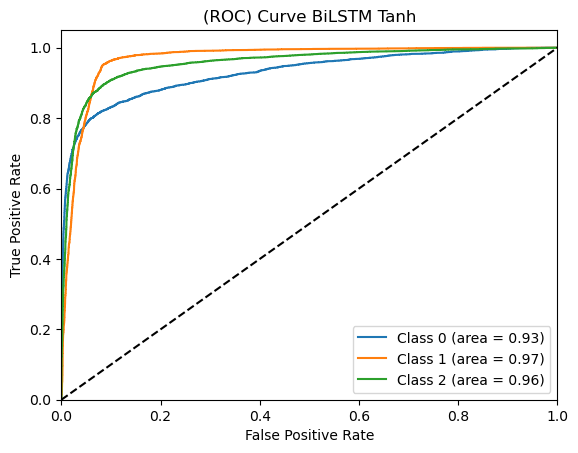

In [17]:
# Plot ROC curve 
fpr = dict() 
tpr = dict() 
roc_auc = dict()  
for i in range(globalvars.nb_classes): 
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred[:, i], pos_label=i)  
    roc_auc[i] = auc(fpr[i], tpr[i]) 

# Plotting the ROC curves
plt.figure() 
for i in range(globalvars.nb_classes): 
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})') 
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate') 
plt.title('(ROC) Curve BiLSTM Tanh')  
plt.legend(loc="lower right")  
plt.show() 

The auc score for all the curves are above 0.9 which indicates excellent performance. It is good at differentiating between the classes